In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2023-11-12 10:35:52--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.1.245.9, 2600:1406:4c00:299::317f, 2600:1406:4c00:2a6::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.1.245.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   154MB/s    in 4.8s    

2023-11-12 10:35:57 (162 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [ ]:
#unzip dataset
!unzip kagglecatsanddogs_5340.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')


In [ ]:
#Create dataframe for input and output
input_path = []
label = []

for class_name in os.listdir('PetImages'):
  for path in os.listdir('PetImages/'+class_name):
    if class_name == 'Cat':
      label.append(0)
    else:
      label.append(1)
    input_path.append(os.path.join("PetImages",class_name,path))
print(input_path[10], label[10])


PetImages/Dog/8774.jpg 1


In [ ]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac = 1).reset_index(drop = True)
df.head

<bound method NDFrame.head of                         images  label
0       PetImages/Cat/2160.jpg      0
1       PetImages/Dog/6397.jpg      1
2        PetImages/Cat/914.jpg      0
3       PetImages/Cat/6613.jpg      0
4      PetImages/Dog/11848.jpg      1
...                        ...    ...
24997  PetImages/Cat/10579.jpg      0
24998  PetImages/Dog/10222.jpg      1
24999   PetImages/Dog/6915.jpg      1
25000   PetImages/Dog/9332.jpg      1
25001   PetImages/Cat/5371.jpg      0

[25002 rows x 2 columns]>

In [ ]:
#delete  db files
for i in df['images']:
  if '.jpg' not in i:
    print(i)


PetImages/Dog/Thumbs.db
PetImages/Cat/Thumbs.db


In [ ]:
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Dog/11702.jpg']
df = df[df['images']!='PetImages/Cat/666.jpg']
len(df)

24998

In [ ]:
import PIL
l = []
for image in df['images']:
  try:
    img = PIL.Image.open(image)
  except:
    l.append(image)

l

[]

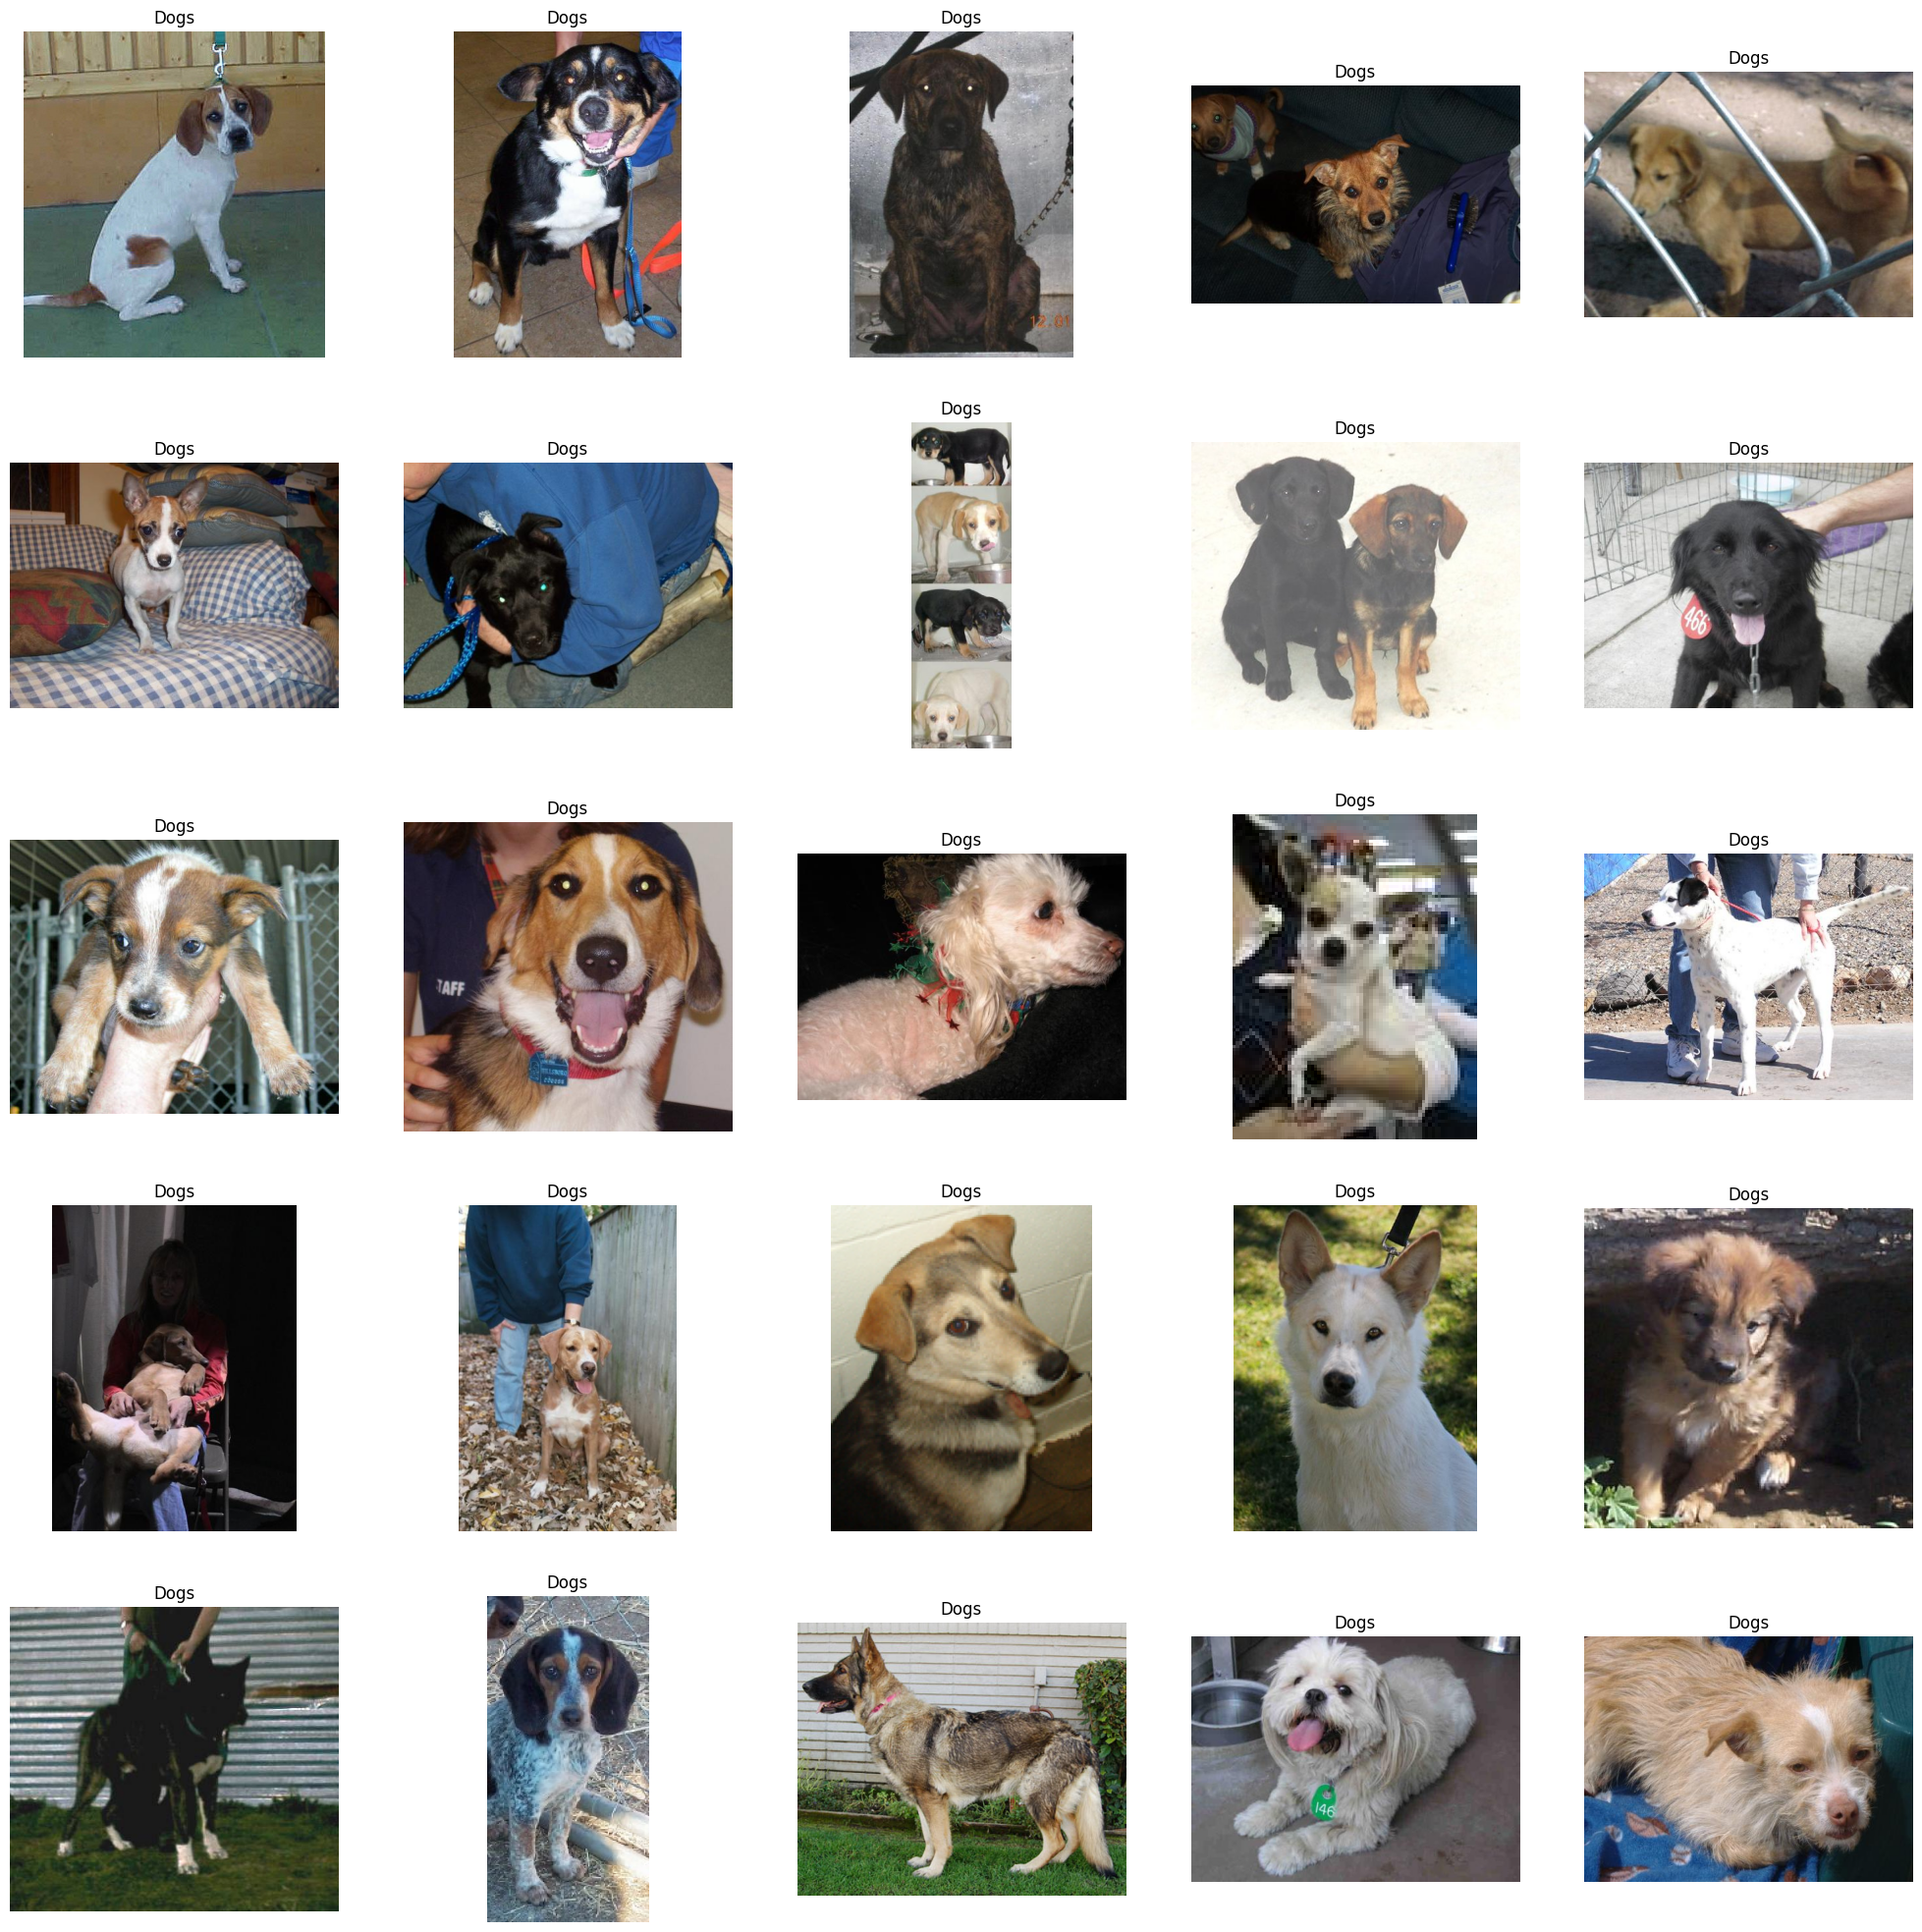

In [ ]:
plt.figure(figsize = (25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start: start+25]

for index, file in enumerate(files):
  plt.subplot(5, 5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Dogs')
  plt.axis('off')

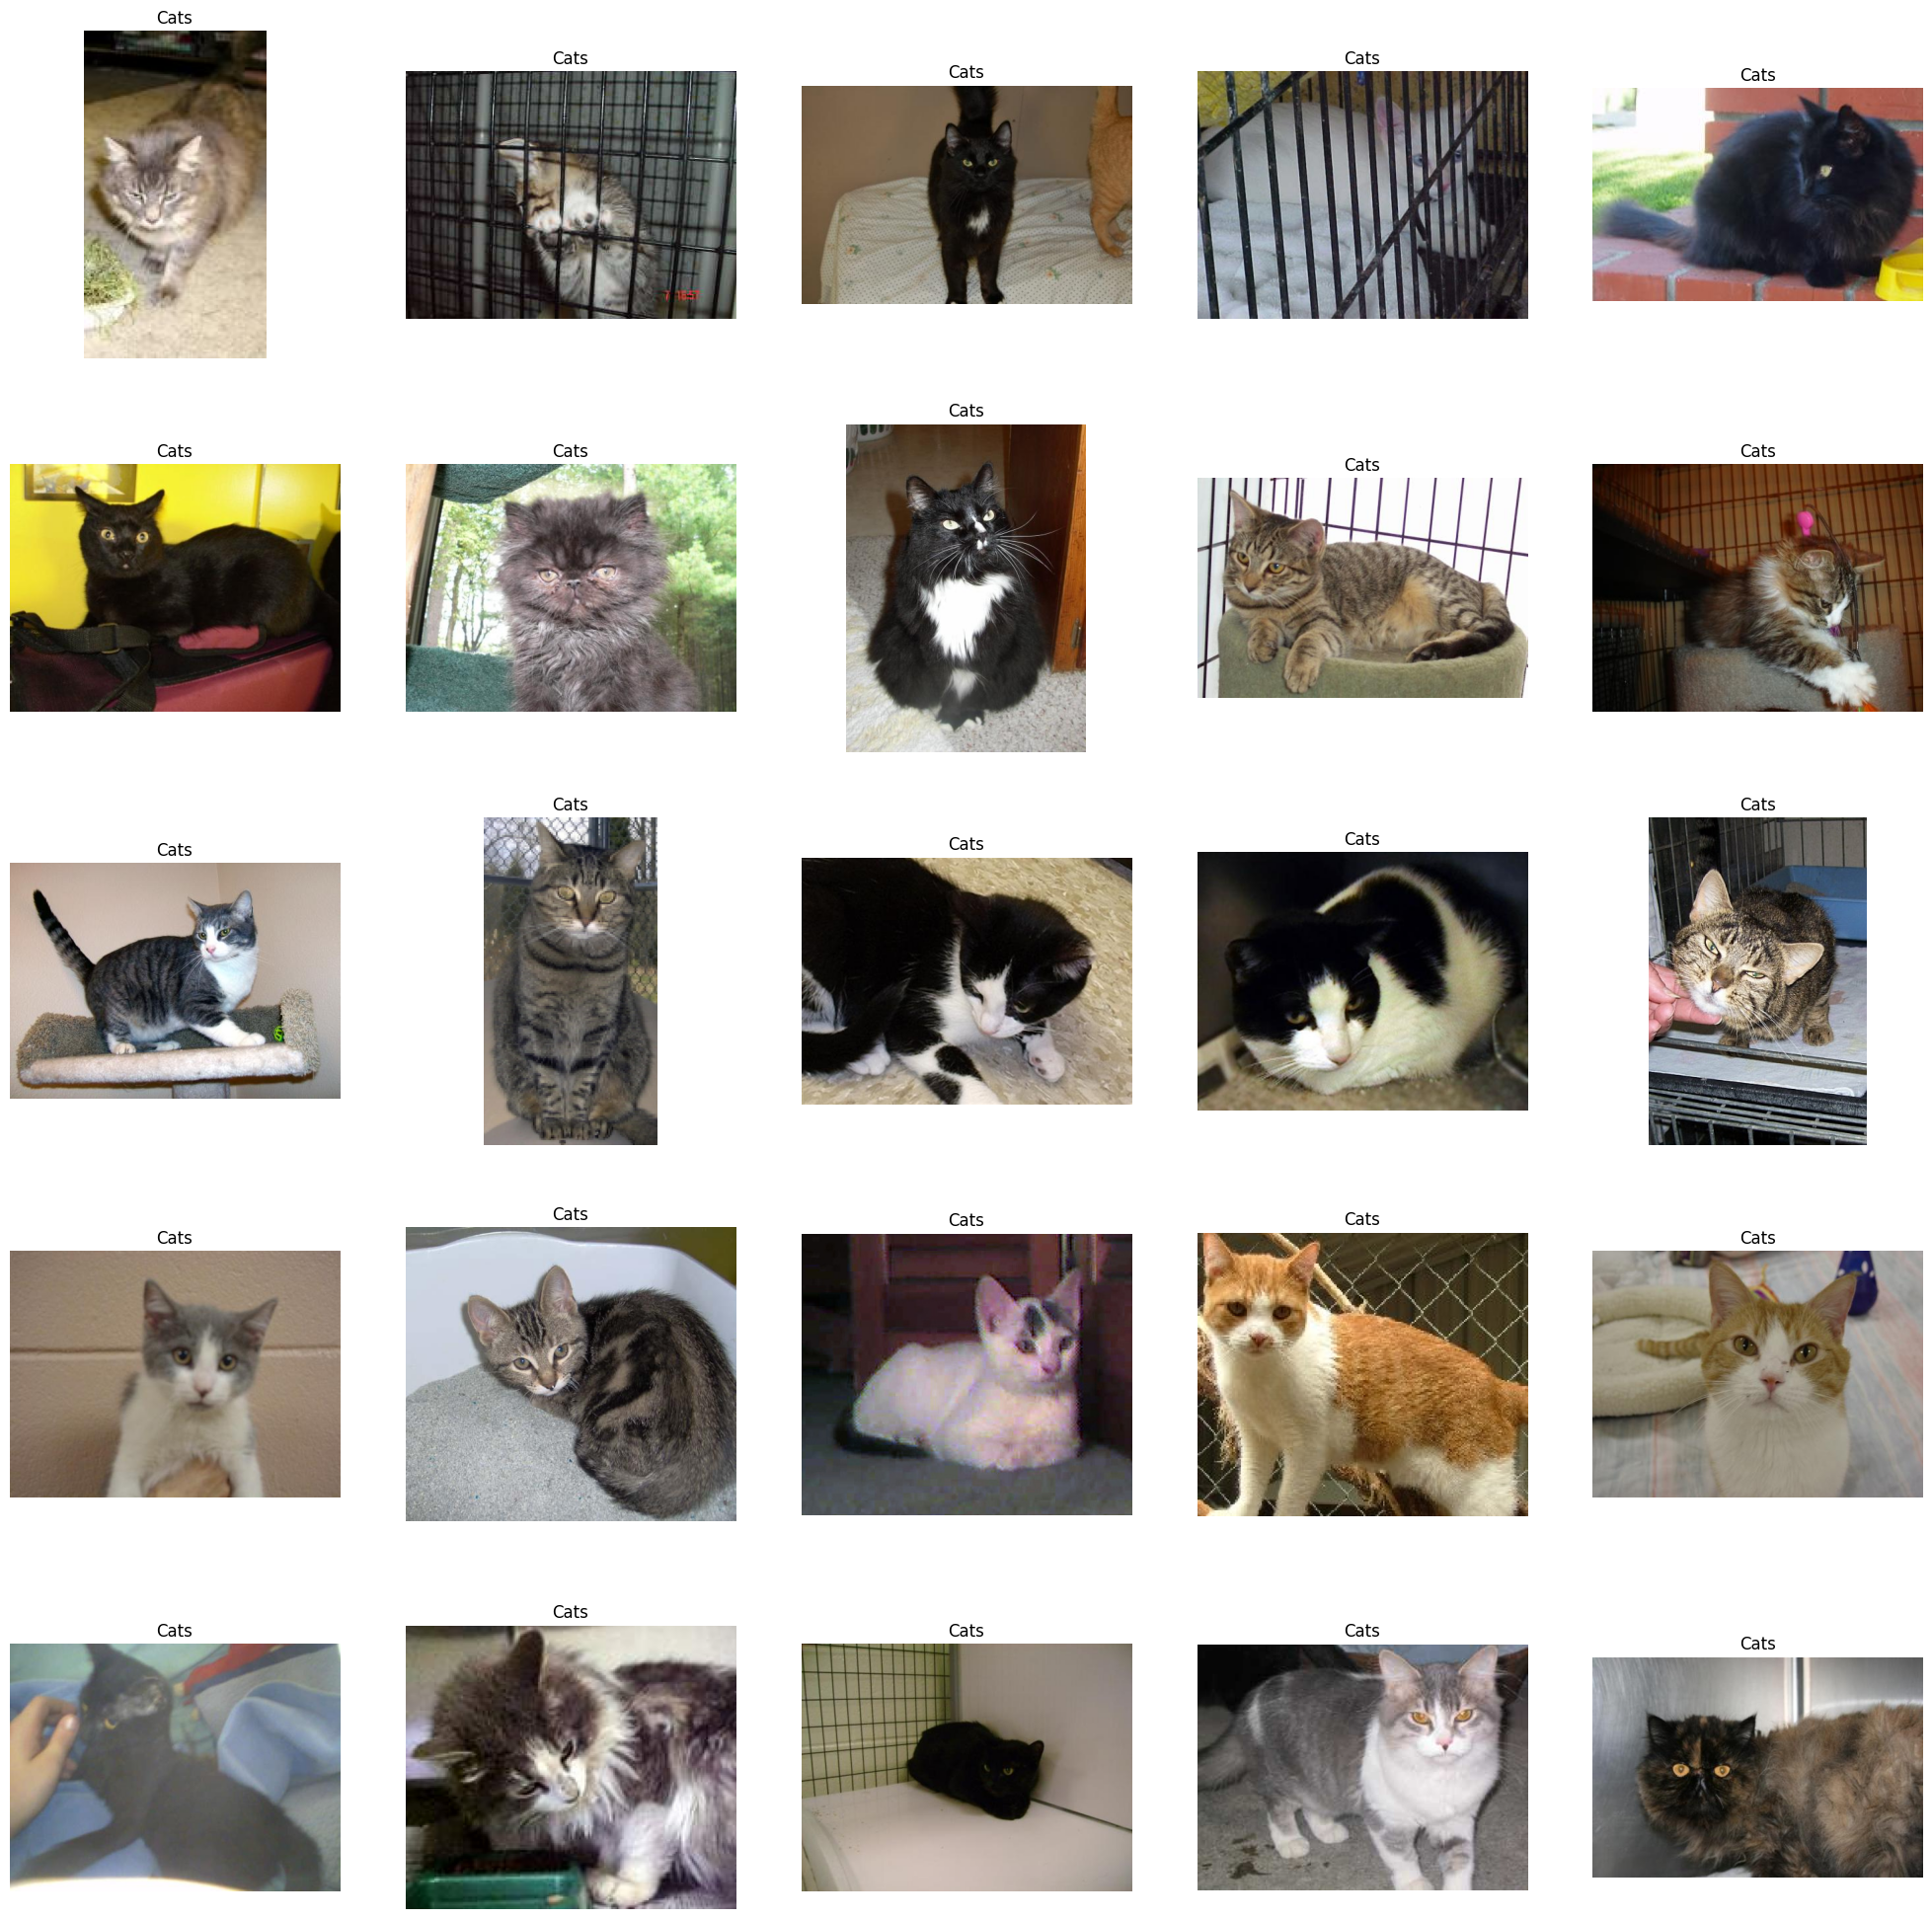

In [ ]:
plt.figure(figsize = (25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start: start+25]

for index, file in enumerate(files):
  plt.subplot(5, 5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Cats')
  plt.axis('off')

<Axes: ylabel='count'>

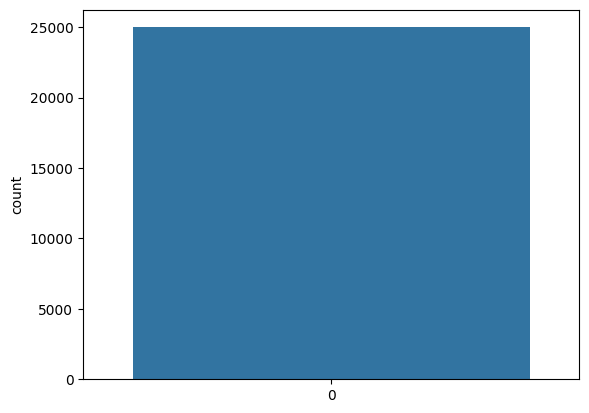

In [ ]:
import seaborn as sns
sns.countplot(df['label'])

In [ ]:
df['label'] = df['label'].astype('str')

In [ ]:
#input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size= 0.2, random_state= 42)

In [ ]:
print(type(train))
print(type(test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255, #normalization
    rotation_range = 40,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train = train_generator.flow_from_dataframe(train, x_col= 'images', y_col='label',target_size = (128,128), batch_size = 512, class_mode = 'binary')

val = val_generator.flow_from_dataframe(test, x_col= 'images', y_col='label',target_size = (128,128), batch_size = 512, class_mode = 'binary')

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


<class 'tuple'>
(128, 128, 3)
<class 'numpy.ndarray'>


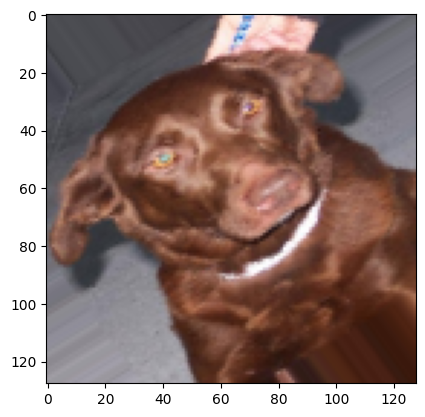

In [ ]:
print(type(train[0]))
print(train[0][0][5].shape)
plt.imshow(train[0][0][5])
print(type(train[0][0][5]))

In [ ]:
#Model creation
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
    Conv2D(16,(3,3), activation = 'relu', input_shape = (128,128,3)),
    MaxPool2D((2,2)),
    Conv2D(32,(3,3), activation = 'relu'),
    MaxPool2D((2,2)),
    Conv2D(64,(3,3), activation = 'relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])


In [ ]:
model.compile(optimizer= 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

In [ ]:
history = model.fit(train, epochs = 10, validation_data = val)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Loss Graph')
plt.legend()
plt.figure()
plt.show()
